# TOG Adversarial Patch

This jupyter notebook demonstrates the use of TOG patches on one of the state-of-the-art object detection algorithms: You Only Look Once v3 (YOLOv3) proposed by Joseph Redmon [[link]](https://pjreddie.com/media/files/papers/YOLOv3.pdf). It has a Darknet53 backbone architecture. More details on the adversarial attacks can be found in the papers listed in the repository [[link]](https://github.com/git-disl/TOG).

## Preparation of Victim Detector

In [ ]:
from attack_utils.patch_utils import extract_roi, evaluate_vanishing_patch, evaluate_mislabeling_patch
from dataset_utils.preprocessing import letterbox_image_padded
from models.yolov3 import YOLOv3_Darknet53
from misc_utils.visualization import visualize_detections
from keras import backend as K
from tqdm import tqdm
from PIL import Image
import numpy as np
import datetime
import os
K.clear_session()

You can download the pretrained weights here [[link]](https://github.com/git-disl/TOG/releases/download/pm-v1.0/YOLOv3_Darknet53.h5) or use the popular repository implementing YOLOv3 in Keras [[link]](https://github.com/qqwweee/keras-yolo3) to train your own model. Once you have downloaded or trained the YOLOv3 detector, you need to *modify* the path in the cell below to point to the `.h5` file. 

In [ ]:
weights = 'model_weights/YOLOv3_Darknet53.h5'  # TODO: Change this path to the victim model's weights
weights = '/research/projects/robust-object-detection/model_weights/YOLOv3_VOC0712_Darknet53.h5'  # TODO: Change this path to the victim model's weights

detector = YOLOv3_Darknet53(weights=weights)

## Configuration of Attack Hyperparameters

In [3]:
ROOT_TRAIN = '/research/datasets/INRIAPerson/Train/pos'
ROOT_TEST = '/research/datasets/INRIAPerson/Test/pos'
ROOT_OUTPUT = './outputs'
NUM_EPOCHS = 100
LR_INIT = 0.1
LR_MULTIPLIER = 0.1
BATCH_SIZE = 8
TOLERANCE_MAX = 5
TOLERANCE_DELTA = 0.01
PATCH_SIZE = (64, 64)
MIN_ROI_SIZE = PATCH_SIZE[0] * PATCH_SIZE[1] * 3
SOURCE_CLASS = 'person'
TARGET_CLASS = 'chair'

fpaths_train = [os.path.join(ROOT_TRAIN, fname) for fname in os.listdir(ROOT_TRAIN)]
fpaths_test = [os.path.join(ROOT_TEST, fname) for fname in os.listdir(ROOT_TEST)]

## Training TOG-vanishing Adversarial Patch

We first initialize the adversarial patch randomly and prepare the output directory.

In [4]:
patch = np.full(shape=(1, *PATCH_SIZE, 3), fill_value=0.50)
min_loss = np.float('inf')
tolerance = 0
lr = LR_INIT

output_folder = os.path.join(ROOT_OUTPUT, 'vanishing',
                             '%s_%s' % (datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"), SOURCE_CLASS))
os.makedirs(output_folder)

We then start running the training for `NUM_EPOCHS` epochs, where each epoch ends with evaluation to monitor the learning process.

In [ ]:
for epoch in range(NUM_EPOCHS):
    ####################################################################################################################
    # Training
    ####################################################################################################################
    epoch_loss = []
    batch_grad, batch_loss = [], []
    np.random.shuffle(fpaths_train)
    for fpath in tqdm(fpaths_train):
        # Preprocess input images
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        if len(rois) == 0:
            continue

        # Apply adversarial patch to each of the rois
        x_adv = x_nat.copy()
        detections_target = detections_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), did in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch

        # Compute gradients
        grad, loss = detector.compute_object_vanishing_gradient_and_loss(x_adv, detections=detections_target)

        # Clip gradients to the area where the adversarial patch is located
        grad = np.mean([grad[:, ymin:ymax, xmin:xmax, :] for _, _, (xmin, ymin, xmax, ymax), _ in rois], axis=0)
        batch_grad.append(grad)
        batch_loss.append(loss)

        if len(batch_loss) == BATCH_SIZE:  # Update the adversarial patch and log the loss over the mini-batch
            patch = np.clip(patch - lr * np.mean(batch_grad, axis=0), 0.0, 1.0)
            epoch_loss.append(np.mean(batch_loss))
            batch_grad, batch_loss = [], []

    ####################################################################################################################
    # Testing
    ####################################################################################################################
    # Baseline = Random permutation of the adversarial patch (i.e., decorrelating pixels)
    patch_rand = np.reshape(patch.copy(), newshape=(patch.shape[0]*patch.shape[1]*patch.shape[2], patch.shape[3]))
    np.random.shuffle(patch_rand)
    patch_rand = np.reshape(patch_rand, newshape=patch.shape)
    num_rois, score_adv, score_rand = 0, 0, 0
    for fpath in fpaths_test:
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        num_rois_x = len(rois)
        if num_rois_x == 0:
            continue

        x_adv, x_rand = x_nat.copy(), x_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), _ in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch
            x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
        detections_adv = detector.detect(x_adv)
        detections_rand = detector.detect(x_rand)

        score_adv_x, score_rand_x = evaluate_vanishing_patch(detector.classes.index(SOURCE_CLASS), rois, detections_adv, detections_rand)
        score_adv += score_adv_x
        score_rand += score_rand_x
        num_rois += num_rois_x

    # Compute training statistics
    epoch_loss = float(np.mean(epoch_loss))
    ASR_TOG = score_adv / num_rois
    ASR_Rand = score_rand / num_rois

    # Save the adversarial patch
    np.save(os.path.join(output_folder, 'Epoch-%d_Loss-%.2f_ASR-%.2f.npy' % (epoch, epoch_loss, ASR_TOG)), patch)

    # Monitor training loss for learning rate scheduling
    if epoch_loss > min_loss - TOLERANCE_DELTA:
        tolerance += 1
        if tolerance >= TOLERANCE_MAX:
            lr *= LR_MULTIPLIER
            tolerance = 0
    else:
        tolerance = 0
    min_loss = min(min_loss, epoch_loss)

    # Print training progress
    print('[Epoch %d] LR: %f | Tol: %d/%d | Min. Loss: %.4f' % (epoch, lr, tolerance + 1, TOLERANCE_MAX, min_loss))
    print('  > Loss      : %.4f' % epoch_loss)
    print('  > ASR (TOG) : %d/%d = %.2f' % (score_adv, num_rois, ASR_TOG))
    print('  > ASR (Rand): %d/%d = %.2f' % (score_rand, num_rois, ASR_Rand))

## Testing TOG-vanishing Adversarial Patch

<Figure size 432x288 with 0 Axes>

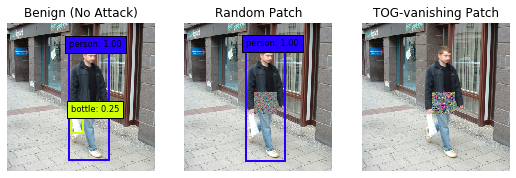

In [15]:
fpath = './assets/example_2.png'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

# Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
rois = extract_roi(detections_query, detector.classes.index(SOURCE_CLASS), x_meta, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)

# Apply adversarial patch to each of the rois
x_adv, x_rand = x_query.copy(), x_query.copy()
for _, _, (xmin, ymin, xmax, ymax), did in rois:
    x_adv[:, ymin:ymax, xmin:xmax, :] = patch
    x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
detections_rand = detector.detect(x_rand, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'Random Patch': (x_rand, detections_rand, detector.model_img_size, detector.classes),
                      'TOG-vanishing Patch': (x_adv, detections_adv, detector.model_img_size, detector.classes)})

## Training TOG-mislabeling Adversarial Patch

We first initialize the adversarial patch randomly and prepare the output directory.

In [16]:
patch = np.full(shape=(1, *PATCH_SIZE, 3), fill_value=0.50)
min_loss = np.float('inf')
tolerance = 0
lr = LR_INIT

output_folder = os.path.join(ROOT_OUTPUT, 'mislabeling',
                             '%s_%s-%s' % (datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
                                           SOURCE_CLASS, TARGET_CLASS))
os.makedirs(output_folder)

We then start running the training for `NUM_EPOCHS` epochs, where each epoch ends with evaluation to monitor the learning process.

In [ ]:
for epoch in range(NUM_EPOCHS):
    ####################################################################################################################
    # Training
    ####################################################################################################################
    epoch_loss = []
    batch_grad, batch_loss = [], []
    np.random.shuffle(fpaths_train)
    for fpath in tqdm(fpaths_train):
        # Preprocess input images
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        if len(rois) == 0:
            continue

        # Apply adversarial patch to each of the rois
        x_adv = x_nat.copy()
        detections_target = detections_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), did in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch
            detections_target[did][0] = detector.classes.index(TARGET_CLASS)

        # Compute gradients
        grad, loss = detector.compute_object_mislabeling_gradient_and_loss(x_adv, detections=detections_target)

        # Clip gradients to the area where the adversarial patch is located
        grad = np.mean([grad[:, ymin:ymax, xmin:xmax, :] for _, _, (xmin, ymin, xmax, ymax), _ in rois], axis=0)
        batch_grad.append(grad)
        batch_loss.append(loss)

        if len(batch_loss) == BATCH_SIZE:  # Update the adversarial patch and log the loss over the mini-batch
            patch = np.clip(patch - lr * np.mean(batch_grad, axis=0), 0.0, 1.0)
            epoch_loss.append(np.mean(batch_loss))
            batch_grad, batch_loss = [], []

    ####################################################################################################################
    # Testing
    ####################################################################################################################
    # Baseline = Random permutation of the adversarial patch (i.e., decorrelating pixels)
    patch_rand = np.reshape(patch.copy(), newshape=(patch.shape[0]*patch.shape[1]*patch.shape[2], patch.shape[3]))
    np.random.shuffle(patch_rand)
    patch_rand = np.reshape(patch_rand, newshape=patch.shape)
    num_rois, score_adv, score_rand = 0, 0, 0
    for fpath in fpaths_test:
        input_img = Image.open(fpath)
        x_nat, x_bbox = letterbox_image_padded(input_img, size=detector.model_img_size)

        # Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
        detections_nat = detector.detect(x_nat)
        rois = extract_roi(detections_nat, detector.classes.index(SOURCE_CLASS), x_bbox, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)
        num_rois_x = len(rois)
        if num_rois_x == 0:
            continue

        x_adv, x_rand = x_nat.copy(), x_nat.copy()
        for _, _, (xmin, ymin, xmax, ymax), _ in rois:
            x_adv[:, ymin:ymax, xmin:xmax, :] = patch
            x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
        detections_adv = detector.detect(x_adv)
        detections_rand = detector.detect(x_rand)

        score_adv_x, score_rand_x = evaluate_mislabeling_patch(detector.classes.index(TARGET_CLASS), rois, detections_adv, detections_rand)
        score_adv += score_adv_x
        score_rand += score_rand_x
        num_rois += num_rois_x

    # Compute training statistics
    epoch_loss = float(np.mean(epoch_loss))
    ASR_TOG = score_adv / num_rois
    ASR_Rand = score_rand / num_rois

    # Save the adversarial patch
    np.save(os.path.join(output_folder, 'Epoch-%d_Loss-%.2f_ASR-%.2f.npy' % (epoch, epoch_loss, ASR_TOG)), patch)

    # Monitor training loss for learning rate scheduling
    if epoch_loss > min_loss - TOLERANCE_DELTA:
        tolerance += 1
        if tolerance >= TOLERANCE_MAX:
            lr *= LR_MULTIPLIER
            tolerance = 0
    else:
        tolerance = 0
    min_loss = min(min_loss, epoch_loss)

    # Print training progress
    print('[Epoch %d] LR: %f | Tol: %d/%d | Min. Loss: %.4f' % (epoch, lr, tolerance + 1, TOLERANCE_MAX, min_loss))
    print('  > Loss      : %.4f' % epoch_loss)
    print('  > ASR (TOG) : %d/%d = %.2f' % (score_adv, num_rois, ASR_TOG))
    print('  > ASR (Rand): %d/%d = %.2f' % (score_rand, num_rois, ASR_Rand))

## Testing TOG-mislabeling Adversarial Patch

<Figure size 432x288 with 0 Axes>

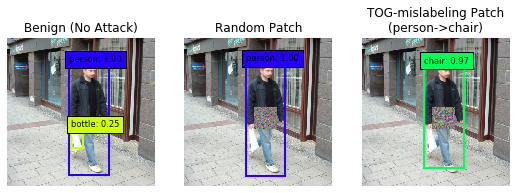

In [14]:
fpath = './assets/example_2.png'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)

# Get roi candidates with an area higher than a predefined threshold to avoid trivial attacks
rois = extract_roi(detections_query, detector.classes.index(SOURCE_CLASS), x_meta, min_size=MIN_ROI_SIZE, patch_size=PATCH_SIZE)

# Apply adversarial patch to each of the rois
x_adv, x_rand = x_query.copy(), x_query.copy()
for _, _, (xmin, ymin, xmax, ymax), did in rois:
    x_adv[:, ymin:ymax, xmin:xmax, :] = patch
    x_rand[:, ymin:ymax, xmin:xmax, :] = patch_rand
detections_adv = detector.detect(x_adv, conf_threshold=detector.confidence_thresh_default)
detections_rand = detector.detect(x_rand, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'Random Patch': (x_rand, detections_rand, detector.model_img_size, detector.classes),
                      'TOG-mislabeling Patch\n(%s->%s)' % (SOURCE_CLASS, TARGET_CLASS): (x_adv, detections_adv, detector.model_img_size, detector.classes)})